<a href="https://colab.research.google.com/github/tahoeskier5/MIT-Data-Science-Course/blob/main/Module_16_Fairness_and_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Import

Import required packages as usual ...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Import and Prep

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIT XPro/german_credit.csv")

In [ ]:
df.head()

,Account_status,Duration,Credit_history,Purpose,Amount,Savings,Employment,Installment_rate,Guarantors,Resident_since,...,Age,Other_plans,Housing,Num_credits,Job,People_maintenance,Phone,Foreign,Gender,repay
0,< 0 DM,6,critical account / other credits existing (not...,radio / television,1169,unknown / no savings account,>= 7 years,4,none,4,...,67,none,A152,2,skilled employee / official,1,"yes, registered under the customers name",yes,Female,1
1,0 < ... < 200 DM,48,existing credits paid back duly till now,radio / television,5951,< 100 DM,1 <= ... < 4 years,2,none,2,...,22,none,A152,1,skilled employee / official,1,none,yes,Male,0
2,no checking account,12,critical account / other credits existing (not...,education,2096,< 100 DM,4 <= ... < 7 years,2,none,3,...,49,none,A152,1,unskilled - resident,2,none,yes,Female,1
3,< 0 DM,42,existing credits paid back duly till now,furniture / equipment,7882,< 100 DM,4 <= ... < 7 years,2,guarantor,4,...,45,none,A153,1,skilled employee / official,2,none,yes,Female,1
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,none,4,...,53,none,A153,2,skilled employee / official,2,none,yes,Female,0




Let's start by splitting the overall dataset into a 70% train and 30% test datasets.


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Logistic Regression Model

Now, let's build a logistic regression model to predict the probability of repayment.
*   Dependent variable is `repay`
*   Independent variables: All the other variables **except** `gender`


In [ ]:
from statsmodels.formula.api import logit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instead of typing in all the variable names, we will do a little Python to create the formula programmatically.

In [ ]:
formula = 'repay ~ ' + ' + '. join(train.columns[:-2])

In [ ]:
formula

'repay ~ Account_status + Duration + Credit_history + Purpose + Amount + Savings + Employment + Installment_rate + Guarantors + Resident_since + Property + Age + Other_plans + Housing + Num_credits + Job + People_maintenance + Phone + Foreign'

In [ ]:
est = logit(formula=formula, data=train).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.456122
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  repay   No. Observations:                  700
Model:                          Logit   Df Residuals:                      654
Method:                           MLE   Df Model:                           45
Date:                Fri, 05 Aug 2022   Pseudo R-squ.:                  0.2518
Time:                        14:36:33   Log-Likelihood:                -319.29
converged:                       True   LL-Null:                       -426.75
Covariance Type:            nonrobust   LLR p-value:                 5.224e-24
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------

In [ ]:
test['pred'] = est.predict(test)

In [ ]:
test['pred'].head()

521    0.618334
737    0.434926
740    0.307760
660    0.724476
411    0.957618
Name: pred, dtype: float64

# Choosing a good cutoff that achieves at least 60% TPR overall

Let's see how the TPR (True Positive Rate) changes as the cutoff increases from 0.0 to 1.0.

In [ ]:
from sklearn.metrics import roc_curve

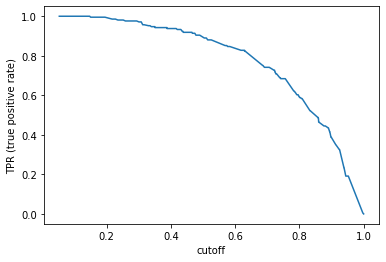

In [ ]:
fpr, tpr, cutoffs = roc_curve(test.repay, test.pred)
cutoffs[0] = 1.0
plt.xlabel('cutoff')
plt.ylabel('TPR (true positive rate)')
plt.plot(cutoffs, tpr)
plt.show()

Let's find the range of cutoffs for which the TPR is at least 60%.

In [ ]:
all_cutoff = cutoffs[tpr >= 0.6][0]

In [ ]:
all_cutoff

0.7959765748336193

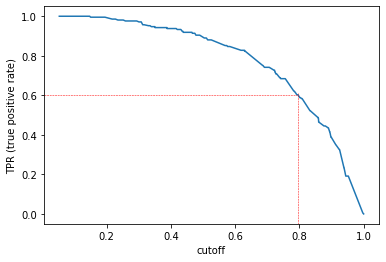

In [ ]:
fpr, tpr, cutoffs = roc_curve(test.repay, test.pred)
cutoffs[0] = 1.0
plt.xlabel('cutoff')
plt.ylabel('TPR (true positive rate)')
plt.plot(cutoffs, tpr)
plt.axhline(y=0.6, xmax=0.95*all_cutoff, color='red', linestyle='--', lw=0.5)
plt.axvline(all_cutoff, ymax=0.6, color='red', linestyle='--', lw=0.5)
plt.show()

In [ ]:
print(f"TPR is at least 60% for cutoffs in the range [0, {all_cutoff:.3f}]")

TPR is at least 60% for cutoffs in the range [0, 0.796]


From this range, we should choose the cutoff that minimizes the FPR. Let's overlay the FPR vs cutoff curve on the chart.

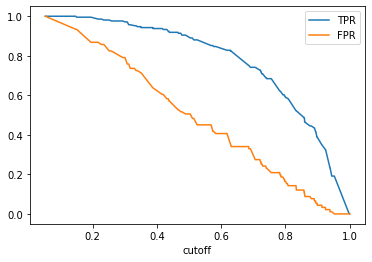

In [ ]:
plt.xlabel('cutoff')
plt.plot(cutoffs, tpr, label='TPR')
plt.plot(cutoffs, fpr, label='FPR')
plt.legend()
plt.show()

Since the FPR decreases as the cutoff increases, we should choose the **maximum possible cutoff** that gives us a TPR of at least 60%. This is, of course, 0.796.

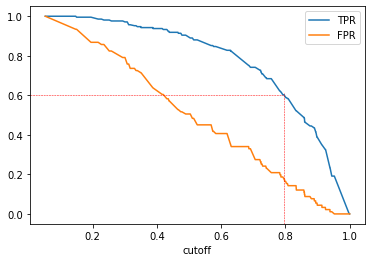

In [ ]:
plt.xlabel('cutoff')
plt.plot(cutoffs, tpr, label='TPR')
plt.plot(cutoffs, fpr, label='FPR')
plt.axhline(y=0.6, xmax=0.95*all_cutoff, color='red', linestyle='--', lw=0.5)
plt.axvline(all_cutoff, ymax=0.6, color='red', linestyle='--', lw=0.5)
plt.legend()
plt.show()

Let's calculate all the 4 metrics from the confusion matrix, for this cutoff.

In [ ]:
from sklearn.metrics import confusion_matrix
tnr, fpr, fnr, tpr  = confusion_matrix(test.repay, test.pred >= all_cutoff, normalize='true').ravel()

In [ ]:
print(f"TPR = {tpr:.3f}, FNR = {fnr:.3f}, FPR = {fpr:.3f}, TNR = {tnr:.3f}")

TPR = 0.603, FNR = 0.397, FPR = 0.176, TNR = 0.824


What's the overall accuracy at this cutoff?

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(test.repay, test.pred >= all_cutoff))

0.67


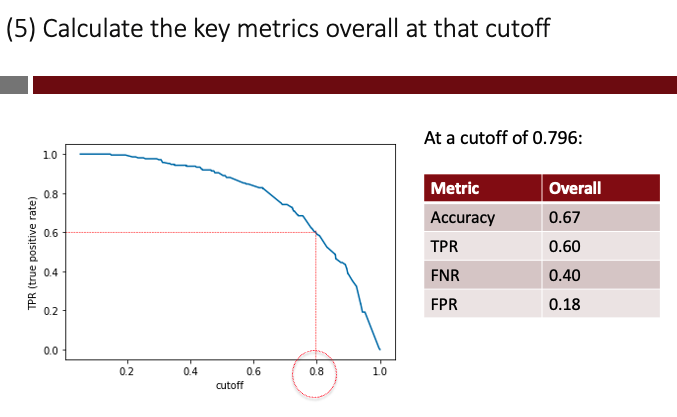

# Identifying Disparity



Recall that we didn't use the `Gender` variable in the logistic regression model. Let's determine if the overall TPR of 60% is similar for each gender group.

In [ ]:
tnr, fpr, fnr, tpr  = confusion_matrix(test.repay[test.Gender=='Female'],
                                       test.pred[test.Gender=='Female'] >= all_cutoff,
                                       normalize='true').ravel()

In [ ]:
acc = accuracy_score(test.repay[test.Gender=='Female'],
              test.pred[test.Gender=='Female'] >= all_cutoff)

In [ ]:
print(f"""Metrics for Gender = Female:
Accuracy = {acc:.2f}
TPR = {tpr:.2f},
FNR = {fnr:.2f}, FPR = {fpr:.2f}, TNR = {tnr:.2f}""")

Metrics for Gender = Female: 
Accuracy = 0.65
TPR = 0.57, 
FNR = 0.43, FPR = 0.18, TNR = 0.82


In [ ]:
tnr, fpr, fnr, tpr  = confusion_matrix(test.repay[test.Gender=='Male'],
                                       test.pred[test.Gender=='Male'] >= all_cutoff,
                                       normalize='true').ravel()

In [ ]:
acc = accuracy_score(test.repay[test.Gender=='Male'],
              test.pred[test.Gender=='Male'] >= all_cutoff)

In [ ]:
print(f"""Metrics for Gender = Male:
Accuracy = {acc:.2f}
TPR = {tpr:.2f},
FNR = {fnr:.2f}, FPR = {fpr:.2f}, TNR = {tnr:.2f}""")

Metrics for Gender = Male: 
Accuracy = 0.73
TPR = 0.68, 
FNR = 0.32, FPR = 0.17, TNR = 0.83


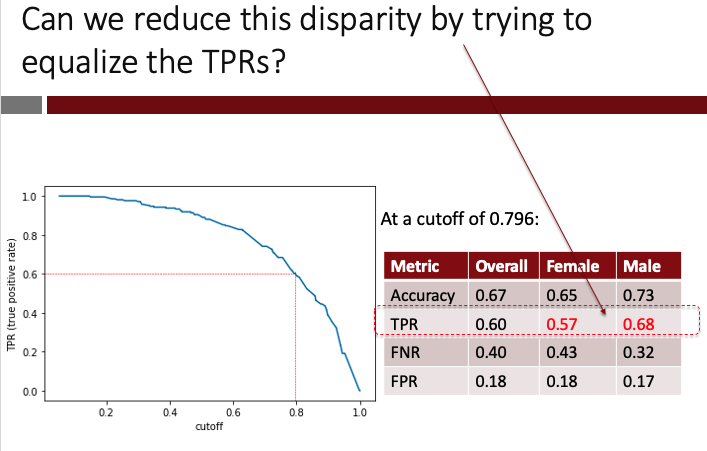

# Mitigating Disparity by Equalizing TPRs

Let's plot the TPR vs cutoff curve for the two groups separately

In [ ]:
_, tpr_female, cutoffs_female = roc_curve(test.repay[test.Gender=='Female'], test.pred[test.Gender=='Female'])
cutoffs_female[0] = 1.0

In [ ]:
_, tpr_male, cutoffs_male = roc_curve(test.repay[test.Gender=='Male'], test.pred[test.Gender=='Male'])
cutoffs_male[0] = 1.0

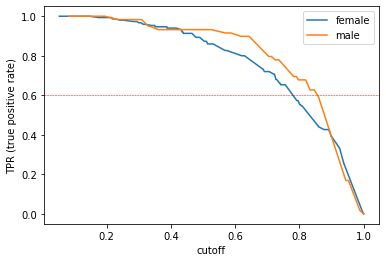

In [ ]:
plt.xlabel('cutoff')
plt.ylabel('TPR (true positive rate)')
plt.plot(cutoffs_female, tpr_female, label='female')
plt.plot(cutoffs_male, tpr_male, label='male')
plt.axhline(y=0.6, color='red', linestyle='--', lw=0.5)
plt.legend()
plt.show()

Now, let's find the best cutoffs for each group.

In [ ]:
female_cutoff = cutoffs_female[tpr_female >= 0.6][0]
male_cutoff = cutoffs_male[tpr_male >= 0.6][0]

In [ ]:
print(f"The optimal cutoff for Gender=Female is {female_cutoff:.2f}")
print(f"The optimal cutoff for Gender=Male is {male_cutoff:.2f}")

The optimal cutoff for Gender=Female is 0.76
The optimal cutoff for Gender=Male is 0.85


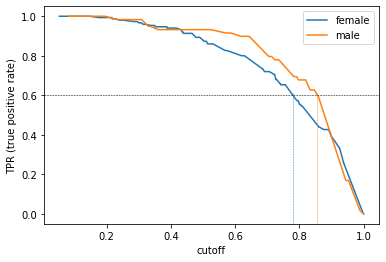

In [ ]:
plt.xlabel('cutoff')
plt.ylabel('TPR (true positive rate)')
plt.plot(cutoffs_female, tpr_female, label='female')
plt.plot(cutoffs_male, tpr_male, label='male')
plt.axhline(y=0.6, color='black', linestyle='--', lw=0.5)
plt.axvline(1.03*female_cutoff, ymax=0.6, color='#1f77b4', linestyle='--', lw=0.5)
plt.axvline(1.01*male_cutoff, ymax=0.6, color='#ff7f0e', linestyle='--', lw=0.5)
plt.legend()
plt.show()

Note that, even after equalization, the TPR for each group **won't be exactly equal** to 60% at these cutoffs since the curve is "jumpy", not smooth. To see this, let's zoom into the chart.

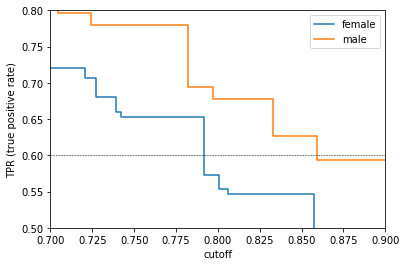

In [ ]:
plt.xlabel('cutoff')
plt.ylabel('TPR (true positive rate)')
plt.xlim(left=0.70, right=0.90)
plt.ylim(bottom=0.5, top=0.8)
plt.plot(cutoffs_female, tpr_female, label='female', drawstyle='steps-pre')
plt.plot(cutoffs_male, tpr_male, label='male', drawstyle='steps-pre')
plt.axhline(y=0.6, color='black', linestyle='--', lw=0.5)
plt.legend()
plt.show()

In the Gender="female" curve, when the cutoff drops below 0.79 to the next lower cutoff of 0.76, the TPR jumps up from 0.57 to 0.65 so we choose 0.76 as the cutoff. But at this cutoff, the TPR is 0.65 (not 0.6) because of the jumpiness of the curve.

Similar reasoning applies to the Gender="Male" curve.

# Impact of TPR Equalization on Metrics

In [ ]:
tnr, fpr, fnr, tpr  = confusion_matrix(test.repay[test.Gender=='Female'],
                                       test.pred[test.Gender=='Female'] >= female_cutoff,
                                       normalize='true').ravel()
acc = accuracy_score(test.repay[test.Gender=='Female'],
              test.pred[test.Gender=='Female'] >= female_cutoff)

print(f"""Metrics for Gender = Female after TPR Equalization:
Accuracy = {acc:.2f}
TPR = {tpr:.2f},
FNR = {fnr:.2f}, FPR = {fpr:.2f}, TNR = {tnr:.2f}""")

Metrics for Gender = Female after TPR Equalization: 
Accuracy = 0.70
TPR = 0.65, 
FNR = 0.35, FPR = 0.19, TNR = 0.81


In [ ]:
tnr, fpr, fnr, tpr  = confusion_matrix(test.repay[test.Gender=='Male'],
                                       test.pred[test.Gender=='Male'] >= male_cutoff,
                                       normalize='true').ravel()
acc = accuracy_score(test.repay[test.Gender=='Male'],
              test.pred[test.Gender=='Male'] >= male_cutoff)

print(f"""Metrics for Gender = Male after TPR Equalization:
Accuracy = {acc:.2f}
TPR = {tpr:.2f},
FNR = {fnr:.2f}, FPR = {fpr:.2f}, TNR = {tnr:.2f}""")

Metrics for Gender = Male after TPR Equalization: 
Accuracy = 0.73
TPR = 0.63, 
FNR = 0.37, FPR = 0.07, TNR = 0.93


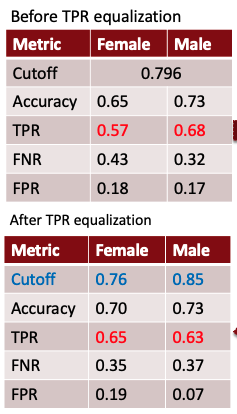